In [1]:
# IF YOU WANT TO USE GOOGLE DRIVE FOR THIS PRACTICAL SESSION : 
#from google.colab import drive

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from TVL2 import * # solutions 

In [3]:
u = plt.imread('../im/simpson512.png')

In [17]:
v = u+np.random.randn(512,512,3)*0.1/np.sqrt(40)
plt.imsave('simpson_noisy0.1_sqrt40.png',v)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


# TVL2 - reminder
In the following, we propose to restore an image thanks to a variationnal TV+L2 model. The observed image $u_b$ is a degraded version of an (unknown) image $u$ through the model : 
$$u_b = Au + b$$
with $A$ a known linear operator,  $b$ a noise image, realisation of a random image with normal distribution $\mathcal{N}(0,Id).$$

The TV-L2 optimization problem we wish to solve is the following
$$\mathrm{argmin}_u \;\;\frac 1 2 \|Au-u_b\|_2^2+\lambda \mathrm{TV}(u)\quad (\mathcal{P}).$$

To this aim, we first rewrite the problem as a saddle point problem
$$\mathrm{arg}\min_u \max_p\underbrace { \frac 1 2 \|Au-u_b\|_2^2+ \; <\lambda \nabla u, p > \;- \iota_{\|.\|_{\infty,i}}(p)}_{H(u,p)}$$
and we  apply the Chambole-Pock algorithm to solve this optimization problem. The algorithm is essentially a proximal gradient descent applied to the function $H(u,p)$, alternatively in $u$ and $p$, with an extra gradient step.

**ALGORITHM**
  - $u_0,p_0$  initialization
  - iterate 
    - $$p_{k+1} = \mathrm{prox}_{-\tau H_{u_k}} (p_k) =\pi_{\|.\|_{\infty,2}}(p_k+\tau \lambda \nabla \bar{u}_k)$$
    - $$ u_{k+1} = \mathrm{prox}_{\sigma H_{p_{k+1}}} (u_k) = (Id+\sigma A A^*)^{-1}\left(u_k +\sigma A^* u_b + \lambda \sigma \mathrm{div}(p_k)\right) $$
    - $$\bar{u}_{k+1} = u_{k+1} + \theta(u_{k+1} - {u}_k)$$



To tis aim, we will need two functions to compute the divergence of a vector field and the gradient of an image. These discretization schemes for these two functions should be chosen such that $\mathrm{div}(\mathrm{grad})$ is a discretization of the laplacian operator. 

In [9]:
def div(cx,cy):
    #cy and cy are coordonates of a vector field.
    #the function compute the discrete divergence of this vector field

    nr,nc=cx.shape

    ddx=np.zeros((nr,nc))
    ddy=np.zeros((nr,nc))

    ddx[:,1:-1]=cx[:,1:-1]-cx[:,0:-2]
    ddx[:,0]=cx[:,0]
    ddx[:,-1]=-cx[:,-2]
  
    ddy[1:-1,:]=cy[1:-1,:]-cy[0:-2,:]
    ddy[0,:]=cy[0,:]
    ddy[-1,:]=-cy[-2,:]
 
    d=ddx+ddy

    return d

In [10]:
def grad(im):
    #compute the gradient of the image 'im'
    # image size 
    nr,nc=im.shape
  
    gx = im[:,1:]-im[:,0:-1]
    gx = np.block([gx,np.zeros((nr,1))])

    gy =im[1:,:]-im[0:-1,:]
    gy=np.block([[gy],[np.zeros((1,nc))]])
    return gx,gy

## TVL2 for denoising

We create the noisy image.

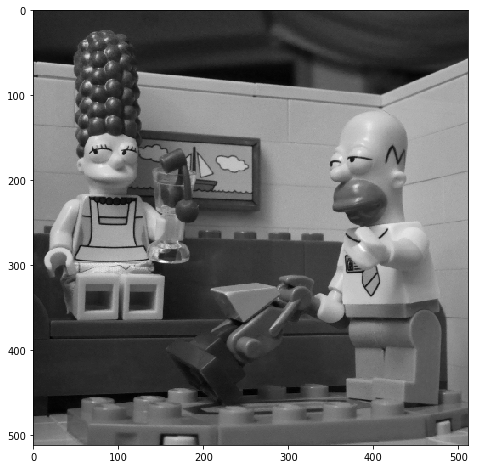

In [2]:
u = plt.imread('../im/simpson512.png')    # images can be found here https://github.com/judelo/notebooks/tree/master/im
u = u[:,:,1]
plt.figure(figsize = (8,8))
plt.imshow(u, cmap = 'gray')

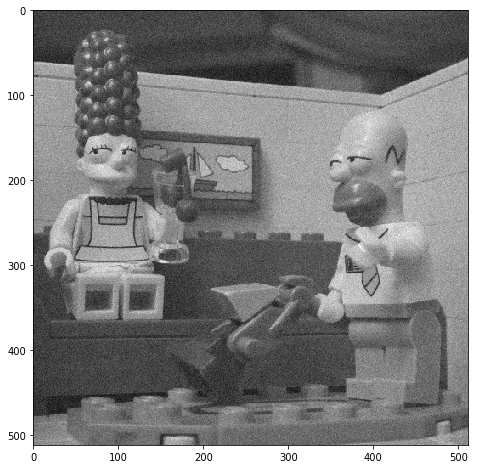

In [3]:
# denoising
sigmanoise = 0.05
nr,nc = u.shape
ub = u+sigmanoise*np.random.randn(nr,nc)
plt.figure(figsize = (8,8))
plt.imshow(ub, cmap = 'gray')

**Write a function `chambolle_pock_prox_TV` implementing the Chambolle-Pock algorithm for TVL2 denoising.** The function should take as inputs the noisy image `ub`, the regularization parameter $\lambda$ and a number of iterations.  

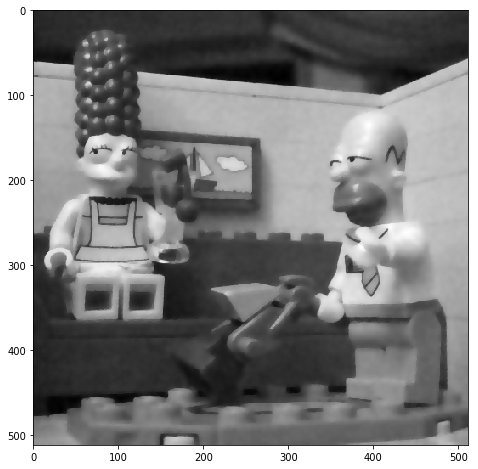

In [4]:
# TVL2 denoising
ut = chambolle_pock_prox_TV(ub,0.1,100)   

#display the result
plt.figure(figsize = (8,8))
plt.imshow(ut,cmap='gray')

# TVL2 for deblurring

In this section, the observed image $u_b$ can be written
$$Au+b$$
where the operator $A$ represents a (circular) convolution with a known kernel $h$. For the sake of simplicity we propose to use a uniform kernel for $h$ but you can try other kinds of kernels. The matrix $A$ is never computed explicitely (it would be HUGE !), all the operations involving $A$ or $A^*$ must be written directly in the Fourier domain. For instance:  
- $Au$ is a convolution with the kernel $h$, it can be computed as 
$$\mathcal{F}^{-1} ( \hat{u}. \hat{h} )$$
with $\mathcal{F}$ the Fourier transform and $\mathcal{F}^{-1}$ the inverse Fourier transform.
- $A^*u$ is a convolution with the conjugate of the kernel $h$...
- the inversion $(Id+\sigma AA^*)^{-1} u $ in the Fourier domain becomes a division  $\frac{\hat{u}}{1+ \sigma |\hat{h}|^2}$

In [5]:
s=4 #kernel definition    (for a 9x9 uniform kernel)
h = np.zeros((u.shape[0],u.shape[1]))
h[0:2*s+1,0:2*s+1] = np.ones((2*s+1, 2*s+1))/(2*s+1)**2

In [6]:
convol  = lambda a,b:  np.real(np.fft.ifft2(np.fft.fft2(a)*np.fft.fft2(b)))

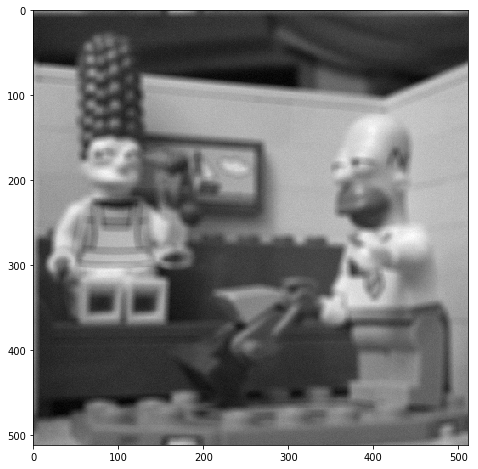

In [7]:
# blurred image
ub = convol(u,h) + 0.01*np.random.randn(u.shape[0],u.shape[1])
plt.figure(figsize = (8,8))
plt.imshow(ub, cmap = 'gray')

**Write a function `chambolle_pock_deblurring_TV` implementing Chambolle-Pock for image deblurring. Try to apply this algorithm to the blurred version of $u$, with or without noise added to the blurred image. How should be chosen the regularization parameter $\lambda$ in each case?** 

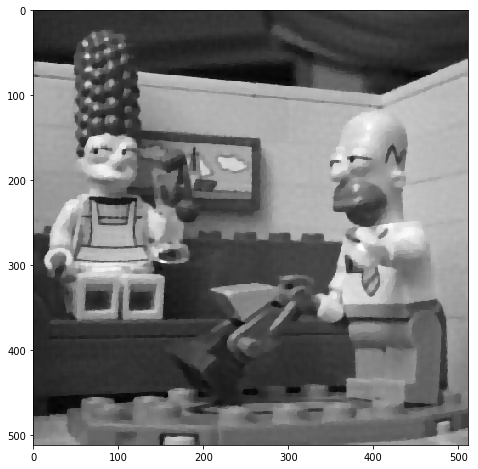

In [8]:
lambd = 1e-3
niter = 200

# TVL2 deblurring
ut = chambolle_pock_deblurring_TV(ub,h,lambd,niter) 

#display result
plt.figure(figsize = (8,8))
plt.imshow(ut,cmap='gray')